**OBJECTIVE:** To describe the template's directory structure, how Docker maps the directories and how to import functions from local custom packages

**AUTHOR:** [@jonjoncardoso](https://github.com/jonjoncardoso)

**NOTEBOOK VERSION:** v1

**DATE:** 2021-09-08

**ASSUMPTIONS:** In this notebook, I am assuming you have heard of [Docker](https://www.wikiwand.com/en/Docker_(software)) already. The first section of the notebook revises the most relevant concepts so if you are relatively acquainted with the idea of virtual machines and virtualisation you will do fine. However, if you have no idea what I am talking about, you never heard of Docker containers or if you don't truly grasp its concepts AND if you want to learn how it works, I highly recommend you reserve a couple of hours of your day to watch this [Docker Tutorial for Beginners - Docker Tutorial for Beginners - A Full DevOps Course on How to Run Applications in Containers](https://www.youtube.com/watch?v=fqMOX6JJhGo).

# Docker and docker-compose: main concepts

In summary, Docker is a software that allows you to run code in a virtual environment called a _container_. Even though this container runs in your computer, it has its own separate environment and _typically_ whatever you install or run within the container will not affect what is installed and running elsewhere in your machine (In practice, it is a lot more complicated than that but let's simplify for now).

It is a very convenient tool for data science teams because **it allows people to run their code independently but within the same software environment**, with the same library versions and software dependencies installed regardless of which operating system they have installed in their machines (Mac, Linux, Windows). It is useful for replicating analysis written by your peers and for making reusable code accesible to everyone in the project, avoiding the error-prone process of copy pasting code. 

Docker containers are defined from a special type of text file called [Dockerfile](https://docs.docker.com/engine/reference/builder/). In this file, you specify the operating system you would like to emulate, its environment variables, install software dependencies (e.g. pip install...), define the working directory among other things. A _Docker image_ will be created once you have written and built this file, which will be re-used internally and efficiently by Docker when you need to run your own container.

A container lives in its own separate world, sort of isolated from the rest of its host machine (your computer), but you can map certain directories and files to volumes within the container so you can create, modify and delete them when running Docker. Doing this with just Docker can get a little too complicated sometimes, so to simplify this process, we use a utility tool called [docker-compose](https://docs.docker.com/compose/). Docker compose allows us to define port and volume mappings as well as environment variables and to customize many other things by using a single yml file.

Here is what the [docker-compose.yml for this template](/../../feature/issue1/jon-initial-docker-structure/docker-compose.yml#L10) looks like:

```yml
version: "3.5"

services:

  notebooks:
    build: notebooks
    environment:
      - JUPYTER_ENABLE_LAB=yes
    volumes:
      - ./notebooks:/mnt/code
      - ./src/python/pkg_name:/mnt/code/pkg_name
      - ./data:/mnt/data/
    ports:
      - 8888:8888
```


The code above maps the directory notebooks to the path `/mnt/code` inside the container -- this is the standard mapping point for our work directory. It also adds the custom python package to the working directory so you can invoke it with `import pkg_name` from notebooks.



**LINKS**
- [Best practices for writing Dockerfiles](https://docs.docker.com/develop/develop-images/dockerfile_best-practices/)
- [What is a Docker container? What is a Docker image?](https://www.docker.com/resources/what-container)
- [Docker Volumes](https://docs.docker.com/storage/volumes/)
- [Overview of docker-compose](https://docs.docker.com/compose/)

# Available Python Packages

## Which python libraries are installed?

Because our template makes use of the [Jupyter Docker Stacks](https://jupyter-docker-stacks.readthedocs.io/en/latest/), the most common libraries will already have been installed in the container.

You can see which python libraries are installed and at which version with the pip list command:

In [1]:
!pip list

Package                       Version
----------------------------- -------------------
alembic                       1.6.5
altair                        4.1.0
anyio                         3.3.0
appdirs                       1.4.4
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         21.2.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.9.3
bleach                        4.0.0
blinker                       1.4
bokeh                         2.3.3
Bottleneck                    1.3.2
brotlipy                      0.7.0
cached-property               1.5.2
certifi                       2021.5.30
certipy                       0.1.3
cffi                          1.14.6
chardet                       4.0.0
charset-normalizer            2.0.0
click                         8.0.1
cloudpickle                   1.6.0
colorama                      0.4.4
conda   

## What if I need to update or install a python package?

If all you need is to run and share Jupyter notebooks, install common scientific computing and data science libraries, you won't probably need to change any Dockerfiles provided in this template. All you have to do is add the package you need to the `notebooks/requirements.txt` file, one package per line.

**It is highly recommended to specify the package version when you add it to the requirements.** For example, we can use ggplot-like functions within python by installing the plotnine library:

```python
plotnine==0.8.0
```


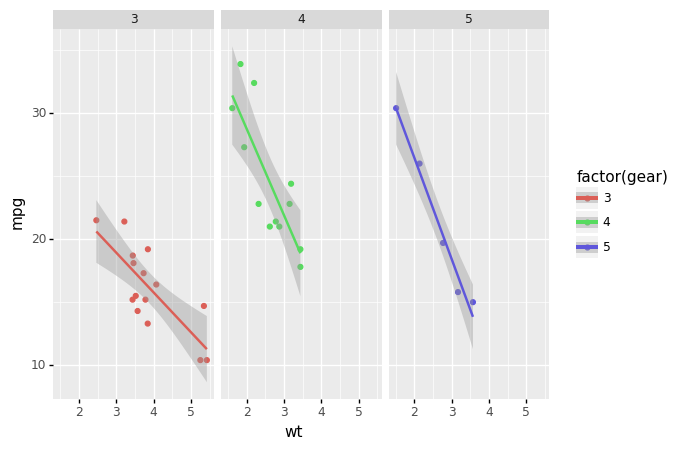

<ggplot: (8732488530294)>

In [2]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars

(ggplot(mtcars, aes('wt', 'mpg', color='factor(gear)'))
 + geom_point()
 + stat_smooth(method='lm')
 + facet_wrap('~gear'))


If the package you are installing requires some OS-related libraries installed, for example Java SDK or a particular C compiler, you will have to add the instructions to install these required libraries to the Dockerfile. This has to be done above the `pip install ...` line for it to be installed in the container before the desired python library is compiled and installed.

After you update Dockerfile or requirements.txt, you have to rebuild your Docker image/container. To do this, kill the Jupyter server that is currently running on your terminal (Ctrl+C), re-build and re-run the notebooks container:

```console
docker-compose build
docker-compose up
```

Don't forget to commit and push the changes to your desired git branch, so your team members can replicate your environment! 

# Docker mappings and directory structure

If you have followed the instructions on the [project's README](/../../main/) and read the instructions above, you are already capable of running this notebook on a Jupyter server from within a Docker container. 

This is accomplished by making the changes you need to the notebooks/Dockerfile and the notebooks/requirements.txt running `docker-compose build` followed by `docker-compose up`.

Like I said above, one thing you have to keep in mind is that home folders and general directories that are visible to us here on the notebook correspond to the files mapped to the container, which are not the same as the directories in your computer!

For example, if you print out the current directory with Unix command [_pwd_](https://www.wikiwand.com/en/Pwd), you will see this:

In [3]:
!pwd

/mnt/code


You know from the section above that `/mnt/code` is mapped to the `<project_root>/notebooks` directory, but how does the container knows it has to start here?

The answer for this is on the [project's Dockerfile](/../../feature/issue1/jon-initial-docker-structure/notebooks/Dockerfile):

```Dockerfile
# Using a default Docker image obtained from https://jupyter-docker-stacks.readthedocs.io/en/latest/index.html
FROM jupyter/scipy-notebook:notebook-6.4.0

USER root

RUN apt update  && apt install -y vim

USER jovyan

# This is what will be the default directory inside the Docker container #
WORKDIR /mnt/code

COPY requirements.txt requirements.txt
RUN pip install --upgrade pip
RUN pip install -r requirements.txt

RUN jupyter labextension install @jupyterlab/toc-extension
```

The command `WORKDIR` specifies the default working directory used whenever you start the container.

# Custom packages

## Empty Directories?

If you list the directories and files in this working directory, you will see the notebooks, the Docker auxiliary files as well as the `pkg_name` directory:

In [4]:
!ls -lth

total 24K
-rwxrwxrwx 1 jovyan 1000  23K Aug  9 19:42 notebook-01-docker-structure.ipynb
-rwxrwxrwx 1 jovyan 1000   45 Aug  9 19:06 requirements.txt
drwxrwxrwx 1 jovyan 1000 4.0K Aug  9 17:57 pkg_name
-rwxrwxrwx 1 jovyan 1000  494 Aug  9 17:45 Dockerfile


But if you access the current working directory from outside the container, using the file browser in your OS, you will find that this `pkg_name` directory is empty!

The reason for this is the mapping that exists on [the docker-compose.yml provided with this template](/../../feature/issue1/jon-initial-docker-structure/docker-compose.yml#L11).

There, we have the following mapping:

```yml
services:

  notebooks:
      volumes:
      - ./src/python/pkg_name:/mnt/code/pkg_name
```

Which translates into: map whatever is on this directory `<project_directory>/src/python/pkg_name` to `/mnt/code/pkg_name` inside the container.

**In practice, this allows you to import your own python functions and classes without [messing with sys.path](https://askubuntu.com/a/471168/439914).**

## Importing a custom python package

This way, you can invoke a function you wrote to `<project_directory>/src/python/pkg_name/__init__.py` by simply calling:

In [5]:
from pkg_name import example_package_function

In [6]:
example_package_function()

This is just an example of a package function.
To import this package and run this function in a notebook, go to the root directory and start the Docker container which contains the Jupyter server:`docker-compose up`.
Then, open a notebook and import `from pkg_name import example_package_function` so you can run `example_package_function()`.


# The end

I hope this notebook has helped you understand how we use Docker containers within this template, how to make small changes such as library versions and how you can import your custom functions to notebooks. 